## Preprocessing

In [1]:
import numpy as np
import pandas as pd
#header = ['userid', 'itemid', 'rating', 'time', 'location', 'companion', 'c']
df = pd.read_csv('./data/movies_context.csv', sep=',', skipinitialspace=True)
n_users = df.userId.unique().shape[0]
n_items = df.movieId.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

Number of users = 943 | Number of movies = 1682


In [2]:
#get the item's rating mean

# df.rating = pd.to_numeric(df.rating, downcast = 'integer', errors='coerce')

items_mean = df.groupby(['movieId'])['rating'].mean()
items_mean.mean()

3.085978829605393

In [3]:
#get the user bias

users_mean = df.groupby(['userId'])['rating'].mean()

overall_mean = df.rating.mean()

users_bias = users_mean - overall_mean

users_bias.mean()

0.04849886035589483

In [4]:
# #get specific user bias (baseline)

# def user_bias(user):
#     u_index = users_mean.index.get_loc(user) #get integer index through the label index
#     u_mean = users_mean[u_index] #get user mean
#     u_bias = u_mean - overall_mean #compute user bias
#     return(u_bias)

In [5]:
#get the contextual factor bias CAMF-CCI (na verdade eu teria que fazer a influencia de cada 
# valor contextual sobre o item e nao de cada categoria de contexto sobre o item CAMF-CCI é uma adap de CAMF-CI)

items_bias = df.groupby(['movieId'])['c'].mean()

total_mean_bias = items_mean.mean()+users_bias.mean()+items_bias.mean()

items_bias.mean()

0.0027524037553050937

In [6]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(df,test_size=0.25)

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

/home/guilherme/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
# Create training and test matrix
R = np.zeros((n_users, n_items))
R.shape
for line in train_data.itertuples():
    R[line[1]-1, line[2]-1] = line[3]

T = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    T[line[1]-1, line[2]-1] = line[3]

In [8]:
# Index matrix for training data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

In [9]:
# Predict the unknown ratings through the dot product of the latent features for users and items 
def prediction(P,Q,IM,UB,IB):
    return (np.dot(P.T,Q)+IM+UB+IB)

In [10]:
lmbda = 0.2 # Regularisation weight
k = 20  # Dimensionality of the latent feature space
m, n = R.shape  # Number of users and items
n_epochs = 100  # Number of epochs
gamma=0.001  # Learning rate

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix

In [11]:
# Calculate the RMSE
def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - (np.dot(P.T,Q)+total_mean_bias))**2)/len(R[R > 0])))

In [12]:
train_errors = []
test_errors = []

#Only consider non-zero matrix 
users,items = R.nonzero()      
for epoch in range(n_epochs):
    for u, i in zip(users,items):
        e = R[u, i] - prediction(P[:,u],Q[:,i],items_mean[i+1],users_bias[u+1],items_bias[i+1])  # Calculate error for gradient
        P[:,u] += gamma * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
        Q[:,i] += gamma * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent movie feature matrix
    #print('user:'+ str(u) + '----item:' + str(i) + '----rating:' + str(R[u, i]) + '----pred:' + str(prediction(P[:,u],Q[:,i],items_mean[i+1],users_bias[u+1],items_bias[i+1])))
    train_rmse = rmse(I,R,Q,P) # Calculate root mean squared error from train dataset
    test_rmse = rmse(I2,T,Q,P) # Calculate root mean squared error from test dataset
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    print("Epoch["+ str(epoch+1) + "/" + str(n_epochs) + "] Train error:" + str(train_rmse) + "-->Test error:" + str(test_rmse))

Epoch[1/100] Train error:5.40864267486-->Test error:5.98401860697
Epoch[2/100] Train error:3.84316339317-->Test error:4.5072692893
Epoch[3/100] Train error:3.11305051508-->Test error:3.82147640852
Epoch[4/100] Train error:2.67229454489-->Test error:3.40483682942
Epoch[5/100] Train error:2.37481473993-->Test error:3.11972778937
Epoch[6/100] Train error:2.16108702579-->Test error:2.91075471473
Epoch[7/100] Train error:2.00117617573-->Test error:2.75040884375
Epoch[8/100] Train error:1.87802324903-->Test error:2.62320483166
Epoch[9/100] Train error:1.78107673228-->Test error:2.51966847542
Epoch[10/100] Train error:1.70342173701-->Test error:2.43364625398
Epoch[11/100] Train error:1.64032706866-->Test error:2.36095582422
Epoch[12/100] Train error:1.58844542471-->Test error:2.29865059912
Epoch[13/100] Train error:1.54534419586-->Test error:2.24459286897
Epoch[14/100] Train error:1.50921611601-->Test error:2.19719334597
Epoch[15/100] Train error:1.47869347737-->Test error:2.15524565991
Epoch

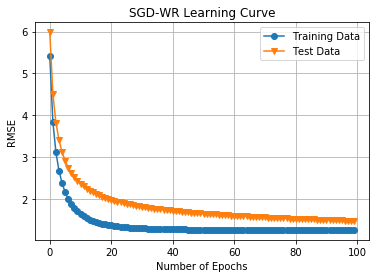

In [13]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('SGD-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

The model seems to perform quite well, with a relatively low RMSE after convergence. The performance can be influenced by tweaking the hyperparameters $\lambda$, $\gamma$ and $k$. In order to learn more about hyperparameter tuning you can take a look at one of the previous [posts](http://online.cambridgecoding.com/notebooks/cca_admin/scanning-hyperspace-how-to-tune-machine-learning-models). 

Next you could compare the actual rating with the predicted rating. To do this you first calculate the prediction matrix – for that you can use ``prediction`` function you have implemented above and convert it to a dataframe for the ease of use.<img src="https://latex.codecogs.com/gif.latex?\hat&space;r_{ui}=P_u^TQ_i$&space;&space;$(2)" title="\hat r_{ui}=p_u^Tq_i" /> 

In [ ]:
# Calculate prediction matrix R_hat (low-rank approximation for R)
R = pd.DataFrame(R)
R_hat=pd.DataFrame(prediction(P,Q))

To get an idea of what you achieved, let's compare some of our predictions for user ``17`` with their actual ratings. 

In [ ]:
# Compare true ratings of user 17 with predictions
ratings = pd.DataFrame(data=R.loc[16,R.loc[16,:] > 0]).head(n=5)
ratings['Prediction'] = R_hat.loc[16,R.loc[16,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']
ratings